In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#import ydata_profiling
import seaborn as sns
import japanize_matplotlib

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import torch 

import warnings
warnings.filterwarnings('ignore')

import logging
# cmdstanpyとProphetのログを警告（WARNING）レベル以上に設定
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/yoshitakanishikawa/.pyenv/versions/3.10.0/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/yoshitakanishikawa/.pyenv/versions/3.10.0/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/yoshitakanishikawa/.pyenv/versions/3.10.0/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/yoshitakanishikawa/.pyenv/versions/3.10.0/lib/python3.10

In [2]:
df = pd.read_csv("stock_price.csv")
df["日付け"] = pd.to_datetime(df["日付け"])
df.head()

,日付け,終値,始値,高値,安値,出来高,変化率 %
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


In [3]:
def convert_volume_with_apply(volume_str):
    """
    出来高の文字列を数値に変換する関数
    """
    if pd.isna(volume_str):
        return np.nan

    volume_str = str(volume_str)

    # 右端の文字で単位を判定
    last_char = volume_str[-1]

    if last_char == 'M':  # ミリオン
        return float(volume_str[:-1]) * 1_000_000
    elif last_char == 'B':  # ビリオン
        return float(volume_str[:-1]) * 1_000_000_000
    elif last_char == 'K':  # キロ
        return float(volume_str[:-1]) * 1_000
    else:  # 単位なし
        return float(volume_str)


def create_lag_features(df: pd.DataFrame, target_col: str = "終値"):
    """
    終値のラグ特徴量を作成する関数
    
    Args:
        df (pd.DataFrame): 元データフレーム（日付と終値を含む）
        target_col (str): ラグを取る対象の列名（デフォルト: "終値"）
    
    Returns:
        pd.DataFrame: ラグ特徴量が追加されたデータフレーム
    """
    # データフレームをコピー
    df_with_lags = df.copy()
    
    # 8日前から30日前までのラグ（1日ずつ）
    for lag in range(8, 31):
        df_with_lags[f"{target_col}_lag_{lag}days"] = df_with_lags[target_col].shift(lag)
    
    # 365日前のラグ（年間の季節性を捉える）
    df_with_lags[f"{target_col}_lag_1y"] = df_with_lags[target_col].shift(365)
    
    return df_with_lags

### 【データ理解　EDA】

In [4]:
df.describe()

,日付け,終値,始値,高値,安値
count,9202,9202.000000,9202.000000,9202.000000,9202.000000
mean,2005-10-21 08:44:04.642469248,92.180961,92.256183,93.176451,91.330146
min,1987-02-12 00:00:00,33.000000,33.000000,33.200000,32.200000
25%,1996-06-06 06:00:00,52.000000,52.100000,52.800000,51.500000
50%,2005-10-11 12:00:00,85.100000,85.100000,86.050000,84.200000
75%,2015-03-04 18:00:00,110.800000,110.800000,111.900000,109.275000
max,2024-08-01 00:00:00,305.900000,309.800000,311.800000,303.900000
std,NaN,50.452228,50.598215,51.049837,50.087405


In [5]:
#### --> 日付け列の内容確認(歯抜け)
start_date = df["日付け"].min()
end_date = df["日付け"].max()

print(f"\n=== 日付範囲 ===")
print(f"開始日: {start_date}")
print(f"終了日: {end_date}")

sample_dates = pd.date_range(start=start_date, end=end_date)
df_dates_set = set(df["日付け"])

# sample_datesにあるが、df_dates_setにはない日付をリスト化
missing_dates = [date for date in sample_dates if date not in df_dates_set]

print(f"\n=== 欠損日付の分析 ===")
# 結果を表示
if len(missing_dates) > 0:
    print(f"欠損の日付count : {len(missing_dates)}")
else:
    print("欠損している日付はありません。")

df_missing_dates = pd.DataFrame(missing_dates, columns=["欠損日"])
df_missing_dates["曜日"] = df_missing_dates["欠損日"].dt.day_name() #曜日の追加

print(f"\n=== 曜日別欠損数 ===")
print(df_missing_dates["曜日"].value_counts())

# 土日以外の欠損
df_weekdays = df_missing_dates.loc[(df_missing_dates['曜日'] != 'Saturday') & (df_missing_dates['曜日'] != 'Sunday')]
print(f"\n土日以外の欠損: {len(df_weekdays)}件")

#土日の行に欠損があるかどうかの確認
df_weekdays = df_missing_dates.loc[(df_missing_dates['曜日'] != 'Saturday') & (df_missing_dates['曜日'] != 'Sunday')]
df_weekdays['祝日'] = df_weekdays['欠損日'].apply(jpholiday.is_holiday)

# 祝日の欠損と祝日ではない欠損を分ける
df_holidays_missing = df_weekdays.loc[df_weekdays['祝日'] == True]
df_simple_missing = df_weekdays.loc[df_weekdays['祝日'] == False]

print(f"祝日の欠損count : {len(df_holidays_missing)}")
print(f"単純欠損の日付count : {len(df_simple_missing)}")


=== 日付範囲 ===
開始日: 1987-02-12 00:00:00
終了日: 2024-08-01 00:00:00

=== 欠損日付の分析 ===
欠損の日付count : 4484

=== 曜日別欠損数 ===
曜日
Saturday     1955
Sunday       1955
Monday        220
Tuesday        90
Thursday       90
Friday         89
Wednesday      85
Name: count, dtype: int64

土日以外の欠損: 574件
祝日の欠損count : 493
単純欠損の日付count : 81


In [6]:
#### --> EDA用レポート表示
#ydata_profiling.ProfileReport(df)

日付け      datetime64[ns]
終値              float64
始値              float64
高値              float64
安値              float64
出来高             float64
変化率 %           float64
dtype: object


<Axes: >

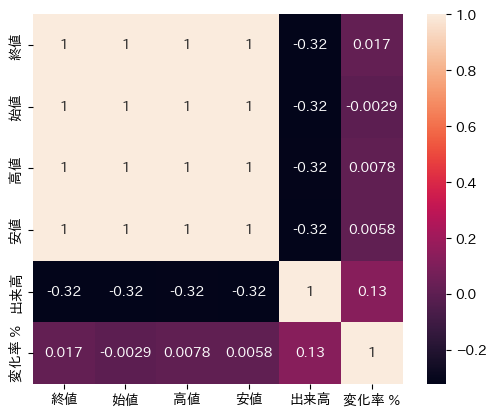

In [7]:
#### --> 出来高列の前処理
df["出来高"].str[-1].unique()
df['出来高'] = df['出来高'].apply(convert_volume_with_apply)

#### --> 変化率列の前処理
df["変化率 %"] = df["変化率 %"].str.replace("%", "").astype(float) / 100

#### --> 日付け列の前処理
#日付け列をdatetime型に変換
df["日付け"] = pd.to_datetime(df["日付け"])
print(df.dtypes)

#日付を並び替え
df = df.sort_values("日付け", ascending=True).reset_index(drop=True)
sns.heatmap(df.select_dtypes(include=[np.float64]).corr(), square=True, annot=True)

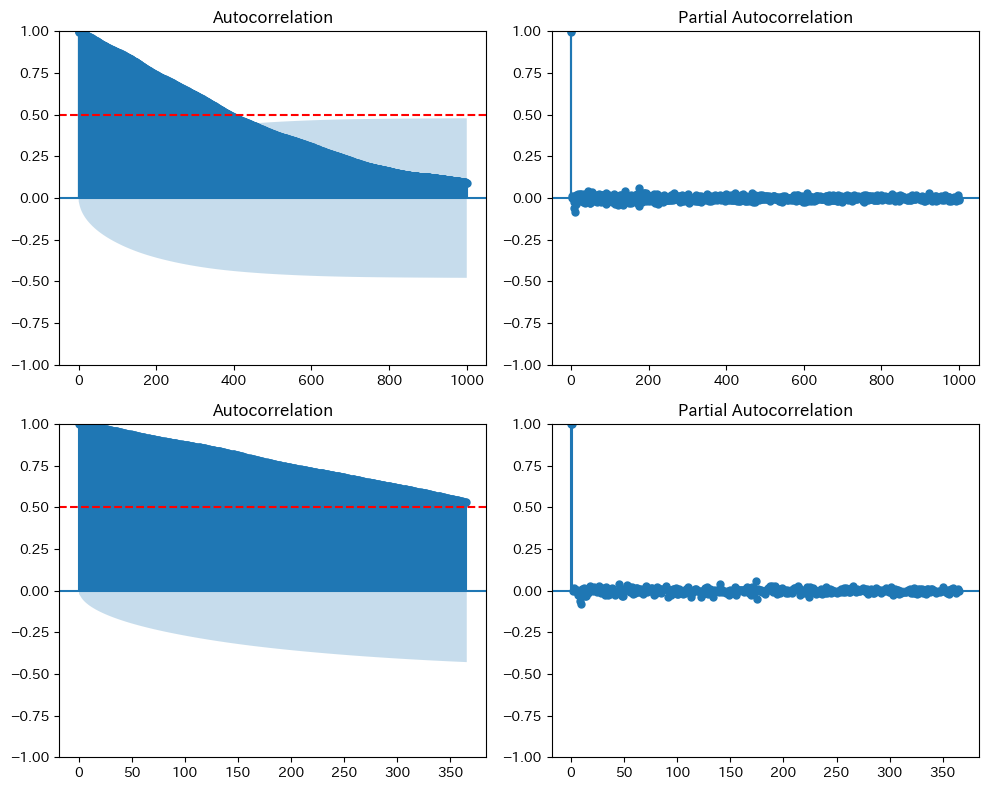

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
plot_acf(df["終値"], ax=ax[0, 0], lags=1000)
ax[0,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[0, 1], lags=1000)

plot_acf(df["終値"], ax=ax[1, 0], lags=365)
ax[1,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[1, 1], lags=365)

fig.tight_layout()
plt.show()

### 【前処理と特徴量エンジニアリング】

In [9]:
###---> 終値に関するLag特徴量の作成
df = create_lag_features(df.copy())
df.tail()

,日付け,終値,始値,高値,安値,出来高,変化率 %,終値_lag_8days,終値_lag_9days,終値_lag_10days,...,終値_lag_22days,終値_lag_23days,終値_lag_24days,終値_lag_25days,終値_lag_26days,終値_lag_27days,終値_lag_28days,終値_lag_29days,終値_lag_30days,終値_lag_1y
9197,2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.0013,157.2,158.7,159.5,...,150.9,149.4,147.0,146.0,145.6,145.5,144.9,146.5,147.8,155.4
9198,2024-07-29,159.7,158.7,160.2,158.4,126280000.0,0.0114,159.7,157.2,158.7,...,151.3,150.9,149.4,147.0,146.0,145.6,145.5,144.9,146.5,153.8
9199,2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.0063,160.8,159.7,157.2,...,151.3,151.3,150.9,149.4,147.0,146.0,145.6,145.5,144.9,153.2
9200,2024-07-31,160.4,158.2,160.7,158.1,173910000.0,0.0107,159.0,160.8,159.7,...,151.8,151.3,151.3,150.9,149.4,147.0,146.0,145.6,145.5,154.0
9201,2024-08-01,156.3,159.3,159.4,156.1,79150000.0,-0.0256,159.9,159.0,160.8,...,156.2,151.8,151.3,151.3,150.9,149.4,147.0,146.0,145.6,154.3


### 【モデルの実装】　Prophet

09:47:21 - cmdstanpy - INFO - Chain [1] start processing
09:47:24 - cmdstanpy - INFO - Chain [1] done processing
09:47:25 - cmdstanpy - INFO - Chain [1] start processing
09:47:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE : 6.522%
MAPE_add : 6.437%


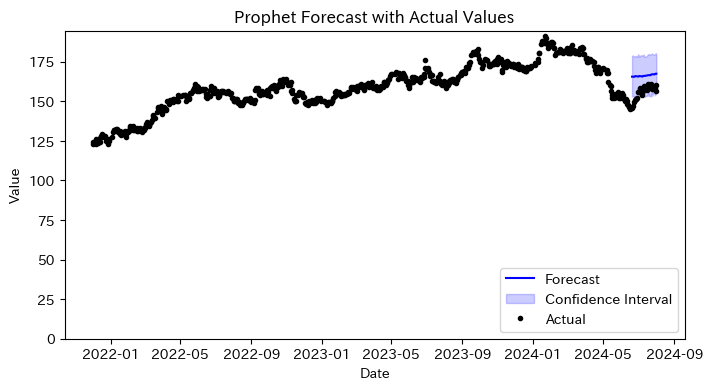

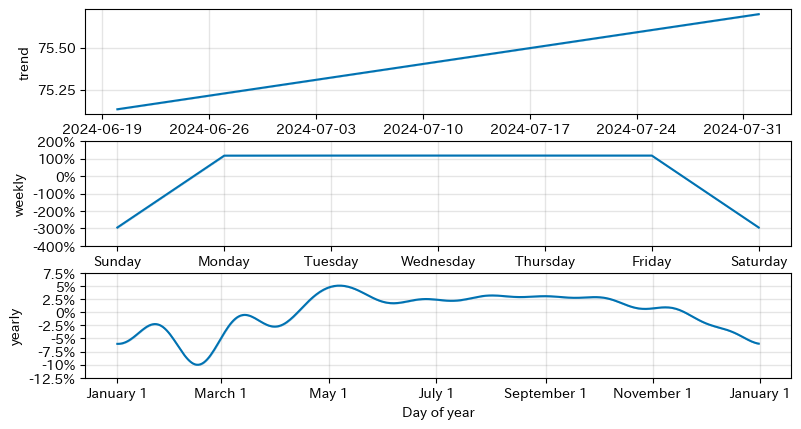

========== 交差検証の実行開始 ==============


09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:37 - cmdstanpy - INFO - Chain [1] done processing
09:47:38 - cmdstanpy - INFO - Chain [1] done processing
09:47:38 - cmdstanpy - INFO - Chain [1] done processing
09:47:38 - cmdstanpy - INFO - Chain [1] start processing
09:47:38 - cmdstanpy - INFO - Chain [1] done processing
09:47:38 - cmdstanpy - INFO - Chain [1] start processing
09:47:39 - cmdstanpy - INFO - Chain [1] start processing
09:47:39 - cmdstanpy - INFO - Chain [1] start processing
09:47:39 - cmdstanpy - INFO - Chain [1] done processing
09:47:39 - cmdstanpy - INFO - Chain 

========== 交差検証の実行終了 ==============
結果をpropphet_cv_results.csvに保存しました


09:48:07 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
from numpy._core.numeric import True_


def Prophet_predictor(df:pd.DataFrame, target:str="終値",sampling_term:int=30,changepoint_prior_scale:float=0.5, seasonality_mode:str='multiplicative',regressors:list=None):
    """
    Prophetモデルを使用して時系列データを予測する関数。

    Args:
        df (DataFrame): 予測に使用するデータフレーム。日付とターゲット変数の列を含む必要があります。
        target (str): 予測対象となる列名（例: '株価終値'）。
        sampling_term (int): 予測精度を評価するために、テストデータとして使用する期間（例: 30日間）
                             のサンプル数を指定します。
        changepoint_prior_scale (float, optional): トレンドの変化点の柔軟性を制御するパラメータ。
                                                   値が大きいほど、トレンドの急激な変化をより多く許容します。
                                                   デフォルトは0.5。
        seasonality_mode (str, optional): 季節性のモデル ('additive' または 'multiplicative') を指定します。
                                          'multiplicative'は、季節性の変動がトレンドの規模に比例して
                                          大きくなるときに適しています。
                                          デフォルトは'multiplicative'。
        regressors (list, optional): 外部変数として使用する列名のリスト（例: ["a", "b"]）。
                                     指定された列はadd_regressor()でモデルに追加されます。
                                     デフォルトはNone。
    Returns:
        tuple: (m, forecast, test_data, train_data)
            - m: 学習済みProphetモデル
            - forecast: 予測結果
            - test_data: テストデータ
            - train_data: 学習用データ
    """
    df_prof = df.rename(columns={"日付け": "ds", target: "y"})
    if not regressors:
        _ = df_prof[["ds","y"]]
        test_data = _.tail(sampling_term)
        train_data = _.drop(test_data.index)
    else:
        test_data = df_prof.tail(sampling_term)
        train_data = df_prof.drop(test_data.index)

    m = Prophet(changepoint_prior_scale=changepoint_prior_scale,seasonality_mode=seasonality_mode)
    # 外部変数の追加
    if regressors:
        for regressor in regressors:
            m.add_regressor(regressor)
    m.fit(train_data)
    #future = test_data[["日付け"]].rename(columns={"日付け":"ds"})
    future = test_data
    forecast = m.predict(future)   #予測値の算出
    return m, forecast, test_data, train_data

def prophet_mape_evaluator(forecast:pd.DataFrame, test_data:pd.Series):
    """
    Prophetモデルの予測精度を平均絶対パーセント誤差（MAPE）で評価する関数。

    Args:
        forecast (DataFrame): Prophetモデルの予測結果を含むデータフレーム。
        actual_data (pd.Series): 実際の値を含むデータ系列。

    Returns:
        float: 計算されたMAPEの値（少数表記）。lowerとupperの予測結果も算出
    """
    y_pred = forecast["yhat"]
    y_test = test_data
    mape_score = mean_absolute_percentage_error(y_test,y_pred)
    return mape_score

def plot_prophet(m, df:pd.DataFrame, forecast:pd.DataFrame, target:str="y", plot_size=(10,6), sample_start_date:str = '2021-12-01'):
    """
    Prophetの予測結果と実際の値を比較プロットする関数。

    Args:
        m: 学習済みProphetモデル
        df : training用dataset
        forecast (DataFrame): Prophetモデルの予測結果を含むデータフレーム。
        target (str, optional): プロット対象となる列名。デフォルトは"終値"。
        plot_size (tuple, optional): プロットのサイズを(幅, 高さ)で指定。デフォルトは(10, 6)。
        sample_start_date (str, optional): 実際の値をプロットする開始日。
        'YYYY-MM-DD'形式で指定。デフォルトは'2021-12-01'。

    Returns:
        tuple: プロットのFigureオブジェクトとAxesオブジェクト (fig, ax)。
    """
    # グラフを描画するaxオブジェクトを作成
    fig, ax = plt.subplots(figsize=plot_size)
    # 1. 予測値をプロット（yhatと信頼区間）
    ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
    actual_data = df.loc[df['ds'] >= sample_start_date]
    ax.plot(actual_data['ds'], actual_data[target], 'k.', label='Actual')
    ax.set_title('Prophet Forecast with Actual Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend(loc='lower right')
    ax.set_ylim(0, None)
    plt.show()
    return fig, ax

def prophet_cv(m, initial_days:int = 5000, period:int = 365, horizon:int = 30, parallel='processes'):
    """
    Prophetモデルに対してウォークフォワード交差検証（Cross Validation）を実行し、
    MAPEなどの評価指標を算出する関数。

    Args:
        m : Prophetインスタンス
        total_rows (int): データ全体の行数（任意。内部では未使用だが、参照用に置いてある）
        initial_days (int): 学習に使用する初期データの期間（日数）。
                            例: 1460 → 最初の約4年分を学習に使う。
        period (int): 検証のステップ幅（日数）。この間隔で学習終了点をずらしながらCVを行う。
                      例: 180 → 半年ごとに予測を検証。
        horizon (int): 予測の先の期間（日数）。
                       例: 30 → 各検証で30日先まで予測して評価。
        parallel (str): 並列処理の実行
                       例：'processes'はCPUの複数のコアを使い、計算を独立して実行するため、大量のデータや複雑なモデルで特に効果的です。

    Returns:
        DataFrame: cross_validation の結果から算出された performance_metrics（MAPE, RMSEなど）。
    """
    print("========== 交差検証の実行開始 ==============")
    df_cv = cross_validation(m, initial=f'{initial_days} days', period=f'{period} days', horizon=f'{horizon} days', parallel=parallel)
    df_p = performance_metrics(df_cv, metrics=['mape'])     # ホライズンごとのMAPE, RMSEなどを計算
    print("========== 交差検証の実行終了 ==============")
    #print(df_p) # 結果の出力
    return df_p

def main():
    rows = len(df) #　データ準備
    target = "終値"
    ###---> 予測
    m, forecast, test_data, train_data = Prophet_predictor(df) # 予測値の算出
    m_add, forecast_add, _, _ = Prophet_predictor(df,seasonality_mode = 'additive') # 予測値の算出

    ###---> 評価
    score = prophet_mape_evaluator(forecast, test_data["y"]) #　評価
    print(f"MAPE : {score *100:.3f}%")
    score_add = prophet_mape_evaluator(forecast_add, test_data["y"]) #　評価
    print(f"MAPE_add : {score_add *100:.3f}%")

    ###---> 可視化
    plot_prophet(m, df.rename(columns={"日付け": "ds", target: "y"}), forecast, plot_size=(8,4)) # 結果の可視化
    fig2 = m.plot_components(forecast)
    fig2.set_size_inches(8, 4)
    plt.show(fig2)

    ###---> 汎化性能の検証
    result = prophet_cv(m)
    result['mape'] = result['mape'].apply(lambda x: f'{x * 100:.3f}%')
    result.to_csv('prophet_cv_results.csv', index=False)
    print("結果をpropphet_cv_results.csvに保存しました")

#メイン関数の実行
if __name__ == "__main__":
    main()

### モデルの修正

DROP後のテーブルデータ数：8837件
add_regressorに追加予定のカラム:['終値_lag_8days', '終値_lag_9days', '終値_lag_10days', '終値_lag_11days', '終値_lag_12days', '終値_lag_13days', '終値_lag_14days', '終値_lag_15days', '終値_lag_16days', '終値_lag_17days', '終値_lag_18days', '終値_lag_19days', '終値_lag_20days', '終値_lag_21days', '終値_lag_22days', '終値_lag_23days', '終値_lag_24days', '終値_lag_25days', '終値_lag_26days', '終値_lag_27days', '終値_lag_28days', '終値_lag_29days', '終値_lag_30days', '終値_lag_1y']


09:48:08 - cmdstanpy - INFO - Chain [1] start processing
09:48:13 - cmdstanpy - INFO - Chain [1] done processing
09:48:14 - cmdstanpy - INFO - Chain [1] start processing
09:48:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE : 1.859%
MAPE_add : 1.953%


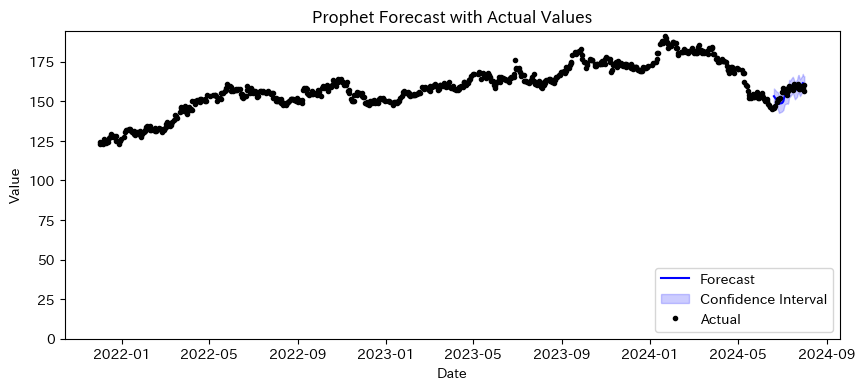

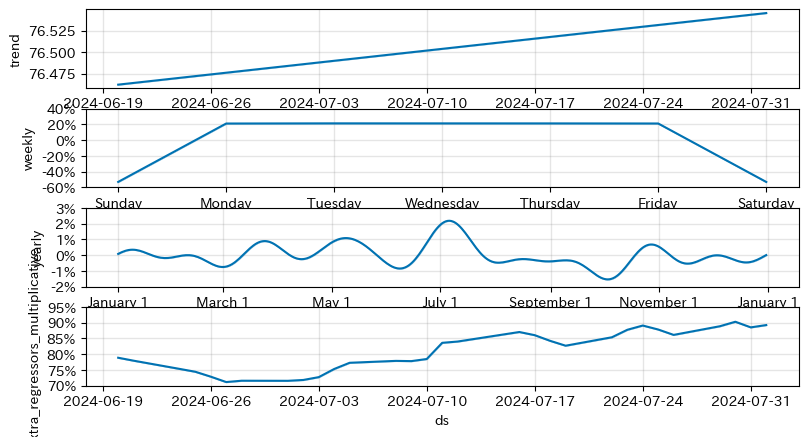

========== 交差検証の実行開始 ==============


09:48:25 - cmdstanpy - INFO - Chain [1] start processing
09:48:25 - cmdstanpy - INFO - Chain [1] start processing
09:48:25 - cmdstanpy - INFO - Chain [1] start processing
09:48:25 - cmdstanpy - INFO - Chain [1] start processing
09:48:25 - cmdstanpy - INFO - Chain [1] start processing
09:48:25 - cmdstanpy - INFO - Chain [1] start processing
09:48:26 - cmdstanpy - INFO - Chain [1] start processing
09:48:26 - cmdstanpy - INFO - Chain [1] start processing
09:48:34 - cmdstanpy - INFO - Chain [1] done processing
09:48:35 - cmdstanpy - INFO - Chain [1] done processing
09:48:36 - cmdstanpy - INFO - Chain [1] start processing
09:48:36 - cmdstanpy - INFO - Chain [1] done processing
09:48:36 - cmdstanpy - INFO - Chain [1] done processing
09:48:37 - cmdstanpy - INFO - Chain [1] done processing
09:48:37 - cmdstanpy - INFO - Chain [1] done processing
09:48:37 - cmdstanpy - INFO - Chain [1] done processing
09:48:37 - cmdstanpy - INFO - Chain [1] start processing
09:48:38 - cmdstanpy - INFO - Chain [1

========== 交差検証の実行終了 ==============
結果をpropphet_cv_results_2.csvに保存しました


09:49:19 - cmdstanpy - INFO - Chain [1] done processing
09:49:19 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
### ---> 新特徴量の付与
def main():
    df_ = df.dropna()
    print(f"DROP後のテーブルデータ数：{len(df_)}件")

    rows = len(df_)
    target = "終値"
    add_reg = [ col for col in df_.columns if "lag" in col]
    print(f"add_regressorに追加予定のカラム:{add_reg}")

    ###---> 予測
    m, forecast, test_data, train_data = Prophet_predictor(df_, regressors=add_reg) # 予測値の算出
    m_add, forecast_add, _, _ = Prophet_predictor(df_,seasonality_mode = 'additive', regressors=add_reg) # 予測値の算出(LAG特徴量を追加)

    ###---> 評価
    score = prophet_mape_evaluator(forecast, test_data["y"]) #　評価
    print(f"MAPE : {score *100:.3f}%")
    score_add = prophet_mape_evaluator(forecast_add, test_data["y"]) #　評価
    print(f"MAPE_add : {score_add *100:.3f}%")

    ###---> 可視化
    plot_prophet(m, df.rename(columns={"日付け": "ds", target: "y"}), forecast, plot_size=(10,4)) # 結果の可視化
    fig2 = m.plot_components(forecast)
    fig2.set_size_inches(8, 4)
    plt.show(fig2)

    ###---> 汎化性能の検証
    result = prophet_cv(m)
    result['mape'] = result['mape'].apply(lambda x: f'{x * 100:.3f}%')
    result.to_csv('prophet_cv_results_2.csv', index=False)
    print("結果をpropphet_cv_results_2.csvに保存しました")

#メイン関数の実行
if __name__ == "__main__":
    main()

データ数: 9202
使用するラグ数: 9200


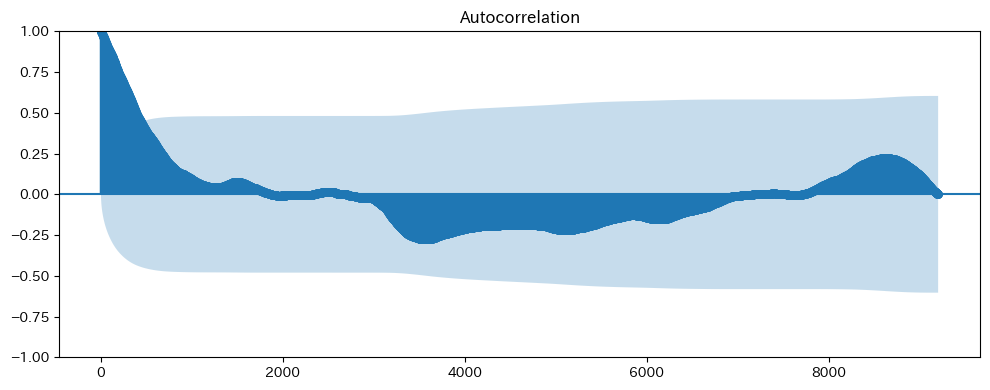

In [ ]:
rows = len(df)

# 適切なラグ数に調整
lags = 9200
fig, ax = plt.subplots(1, 1, figsize=(10,4))
plot_acf(df["終値"], ax=ax, lags=lags)  # ax[0] → ax
fig.tight_layout()
plt.show()